# Poker Agent V14: Advanced Reward Shaping for Proper Poker Strategy

**Key Improvements over V13:**
1. **Risk Penalty**: Discourages excessive all-ins with weak hands
2. **Value Extraction Bonus**: Rewards maximizing winnings with strong hands
3. **Action-Hand Consistency**: Rewards matching bet sizing to hand strength
4. **Pot Building Bonus**: Rewards gradual pot building over overbetting

**Goal:** Train an agent that plays proper, balanced poker rather than pure aggression.

In [1]:
import sys
import os
# Add project root and src directories to path
project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if '__file__' in dir() else os.getcwd()
while 'src' not in os.listdir(project_root) and project_root != '/':
    project_root = os.path.dirname(project_root)
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src', 'models'))
sys.path.insert(0, os.path.join(project_root, 'src', 'workers'))

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import List, Dict
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

# Import V14 modules
from poker_worker_v14 import run_single_episode_v14
from poker_model_v14 import (
    DuelingPokerNet, PrioritizedReplayBuffer, NUM_ACTIONS_V14,
    compute_hand_strength_category, compute_v14_shaped_reward,
    compute_risk_penalty, compute_value_extraction_bonus,
    compute_action_consistency, compute_pot_building_bonus
)

# Constants
SEED = 42
NUM_ACTIONS = NUM_ACTIONS_V14  # 6 actions

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti


In [2]:
# ============================================
# CONFIGURABLE SETTINGS
# ============================================

# Multiprocessing
NUM_WORKERS = 6              # Number of parallel processes
EPISODES_PER_BATCH = 64      # Episodes to collect before training
EQUITY_ITERATIONS = 20       # Monte Carlo iterations for equity

# Training
BATCH_SIZE = 512             # Training batch size
BUFFER_CAPACITY = 300000     # Replay buffer size

# Prioritized Replay parameters
PER_ALPHA = 0.6              # Priority exponent (0=uniform, 1=full priority)
PER_BETA_START = 0.4         # Initial importance sampling weight
PER_BETA_FRAMES = 100000     # Frames to anneal beta to 1.0

# Logging
LOG_PERCENT = 2              # Log every X% of training
CHECKPOINT_PERCENT = 10      # Detailed checkpoint every X%

# V14 Opponent Pool
OPPONENT_TYPES = ['TAG', 'LAG', 'Rock', 'CallingStation', 'MixedBalanced']

print(f"CPU cores: {mp.cpu_count()}, using {NUM_WORKERS} workers")
print(f"Logging every {LOG_PERCENT}%, checkpoints every {CHECKPOINT_PERCENT}%")
print(f"Opponent pool: {', '.join(OPPONENT_TYPES)}")
print(f"Action space: {NUM_ACTIONS} actions (expanded bet sizing)")
print("\nV14 Reward Shaping:")
print("  - Risk penalty for weak-hand all-ins")
print("  - Value extraction bonus for pot building")
print("  - Action-hand consistency rewards")
print("  - Pot building bonus for multi-street value")

CPU cores: 8, using 6 workers
Logging every 2%, checkpoints every 10%
Opponent pool: TAG, LAG, Rock, CallingStation, MixedBalanced
Action space: 6 actions (expanded bet sizing)

V14 Reward Shaping:
  - Risk penalty for weak-hand all-ins
  - Value extraction bonus for pot building
  - Action-hand consistency rewards
  - Pot building bonus for multi-street value


In [3]:
# ============================================
# V14 Reward Shaping (Main Entry Point)
# ============================================

def compute_shaped_reward_v14(result: Dict) -> float:
    """
    V14 reward shaping with proper poker strategy incentives.
    
    Uses worker-computed shaped_reward which includes:
    1. Risk penalty for excessive all-ins
    2. Value extraction bonus
    3. Action-hand consistency
    4. Pot building bonus
    
    This function can apply additional notebook-side shaping if needed.
    """
    # V14: Worker already computes shaped reward with all components
    shaped_reward = result.get('shaped_reward', result['final_reward'])
    
    # Additional EV-based adjustments (from V13, for continuity)
    ev_adjustment = 0.0
    contexts = result.get('contexts', [])
    actions = result.get('actions', [])
    final_profit = result['final_reward']
    
    for ctx, action in zip(contexts, actions):
        if not ctx:
            continue
        
        excess_equity = ctx.get('excess_equity', 0)
        pot_bb = ctx.get('pot_bb', 0)
        to_call_bb = ctx.get('to_call_bb', 0)
        
        if action == 0:  # Fold
            if excess_equity < -0.05:  # Good fold
                ev_adjustment += 0.3 * abs(excess_equity)
            elif excess_equity > 0.1:  # Bad fold
                ev_adjustment -= 0.4 * excess_equity
        elif action == 1:  # Call
            if to_call_bb > 0:
                if excess_equity > 0.05:  # Good call
                    ev_adjustment += 0.15 * excess_equity
                elif excess_equity < -0.1:  # Bad call
                    ev_adjustment -= 0.4 * abs(excess_equity) * (pot_bb / 10.0 + 1)
    
    # Pot importance scaling
    if contexts:
        last_pot = contexts[-1].get('pot_bb', 10)
        pot_importance = min(last_pot / 15.0, 3.0)
        
        if final_profit > 0:
            ev_adjustment *= (1 + 0.05 * pot_importance)
        else:
            ev_adjustment *= (1 + 0.1 * pot_importance)
    
    return shaped_reward + ev_adjustment

In [4]:
# ============================================
# V14 Agent with Dueling DQN & Prioritized Replay
# ============================================

class DuelingAgent:
    def __init__(self, state_dim=385, lr=5e-5):
        self.model = DuelingPokerNet(state_dim).to(device)
        self.target_model = DuelingPokerNet(state_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999  # Will be recalculated based on batches
        
        # Prioritized replay buffer
        self.buffer = PrioritizedReplayBuffer(
            capacity=BUFFER_CAPACITY,
            alpha=PER_ALPHA,
            beta_start=PER_BETA_START,
            beta_frames=PER_BETA_FRAMES
        )
    
    def add_transitions(self, transitions):
        self.buffer.push_batch(transitions)
    
    def decay_epsilon(self):
        """Decay epsilon once per batch (called from training loop)."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def train_step(self, batch_size=BATCH_SIZE):
        if len(self.buffer) < batch_size:
            return 0.0
        
        # Sample with priorities
        batch, indices, weights = self.buffer.sample(batch_size)
        
        states = torch.FloatTensor(np.array([t[0] for t in batch])).to(device)
        actions = torch.LongTensor([t[1] for t in batch]).to(device)
        rewards = torch.FloatTensor([t[2] for t in batch]).to(device)
        next_states = torch.FloatTensor(np.array([t[3] for t in batch])).to(device)
        dones = torch.FloatTensor([t[4] for t in batch]).to(device)
        weights_tensor = torch.FloatTensor(weights).to(device)
        
        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        
        # Double DQN
        with torch.no_grad():
            next_actions = self.model(next_states).argmax(1, keepdim=True)
            next_q = self.target_model(next_states).gather(1, next_actions)
            target_q = rewards.unsqueeze(1) + self.gamma * next_q * (1 - dones.unsqueeze(1))
        
        # TD errors for priority updates
        td_errors = (current_q - target_q).detach().cpu().numpy().flatten()
        
        # Weighted loss
        loss = (weights_tensor * F.smooth_l1_loss(current_q, target_q, reduction='none').squeeze()).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        # Update priorities
        self.buffer.update_priorities(indices, td_errors)
        
        return loss.item()
    
    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def get_model_state_dict_cpu(self):
        return {k: v.cpu() for k, v in self.model.state_dict().items()}

In [5]:
# ============================================
# Training Loop (V11/V12/V13 Style Logging)
# ============================================

def train_v14_parallel(num_hands=100000):
    agent = DuelingAgent(state_dim=385)
    
    # Calculate epsilon decay based on batches
    total_batches = num_hands // EPISODES_PER_BATCH
    decay_batches = int(total_batches * 0.8)
    agent.epsilon_decay = (agent.epsilon_min / agent.epsilon) ** (1.0 / decay_batches)
    
    # Tracking
    all_rewards = []
    all_shaped = []
    loss_history = []
    action_counts_total = {i: 0 for i in range(NUM_ACTIONS)}
    
    # Per-opponent tracking
    opp_stats = {opp: {'rewards': [], 'shaped': [], 'wins': 0, 'hands': 0} 
                 for opp in OPPONENT_TYPES}
    
    # V14: Track risk metrics
    risk_metrics = {'allin_count': 0, 'allin_with_weak': 0, 'allin_with_strong': 0}
    
    total_hands = 0
    batch_count = 0
    start_time = time.time()
    
    # Logging intervals
    log_interval = max(1, int(num_hands * LOG_PERCENT / 100))
    checkpoint_interval = max(1, int(num_hands * CHECKPOINT_PERCENT / 100))
    next_log = log_interval
    next_checkpoint = checkpoint_interval
    
    print("="*70)
    print(f"TRAINING V14 (Advanced Reward Shaping, {NUM_WORKERS} workers)")
    print("="*70)
    print(f"Total hands: {num_hands:,}")
    print(f"Episodes per batch: {EPISODES_PER_BATCH}")
    print(f"Total batches: {total_batches:,}")
    print(f"Opponent pool: {', '.join(OPPONENT_TYPES)}")
    print(f"Action space: {NUM_ACTIONS} actions")
    print(f"\nEpsilon schedule:")
    print(f"  Start: {agent.epsilon:.2f}")
    print(f"  Target: {agent.epsilon_min:.2f} at batch {decay_batches:,} (80% of training)")
    print(f"  Decay factor per batch: {agent.epsilon_decay:.6f}")
    print("\nV14 Reward Components:")
    print("  - Risk penalty for weak-hand aggression")
    print("  - Value extraction bonus")
    print("  - Action-hand consistency")
    print("  - Pot building bonus")
    print("="*70)
    
    try:
        ctx = mp.get_context('fork')
        print("\nUsing 'fork' context for multiprocessing")
    except:
        ctx = mp.get_context('spawn')
        print("\nUsing 'spawn' context for multiprocessing")
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
        while total_hands < num_hands:
            model_state_dict = agent.get_model_state_dict_cpu()
            
            # Prepare episode arguments
            episode_args = []
            for i in range(EPISODES_PER_BATCH):
                seed = random.randint(0, 2**31-1)
                opp = random.choice(OPPONENT_TYPES)
                episode_args.append((seed, agent.epsilon, opp, EQUITY_ITERATIONS, model_state_dict))
            
            # Run episodes in parallel using V14 worker
            futures = [executor.submit(run_single_episode_v14, args) for args in episode_args]
            
            batch_rewards = []
            batch_shaped = []
            batch_transitions = []
            batch_action_counts = {i: 0 for i in range(NUM_ACTIONS)}
            
            for future in as_completed(futures):
                try:
                    result = future.result()
                    
                    # V14: Compute shaped reward with new reward system
                    shaped = compute_shaped_reward_v14(result)
                    
                    batch_rewards.append(result['final_reward'])
                    batch_shaped.append(shaped)
                    
                    # Update transitions with shaped reward
                    for t in result['transitions']:
                        obs, action, _, next_obs, done = t
                        reward = shaped if done else 0.0
                        batch_transitions.append((obs, action, reward, next_obs, done))
                    
                    # Track action counts
                    for a, c in result['action_counts'].items():
                        batch_action_counts[a] += c
                        action_counts_total[a] += c
                    
                    # V14: Track risk metrics
                    equities = result.get('equities', [])
                    actions = result.get('actions', [])
                    for eq, act in zip(equities, actions):
                        if act == 5:  # All-in
                            risk_metrics['allin_count'] += 1
                            strength = compute_hand_strength_category(eq)
                            if strength >= 3:
                                risk_metrics['allin_with_strong'] += 1
                            else:
                                risk_metrics['allin_with_weak'] += 1
                    
                    # Per-opponent stats
                    opp_type = result['opp_type']
                    opp_stats[opp_type]['rewards'].append(result['final_reward'])
                    opp_stats[opp_type]['shaped'].append(shaped)
                    opp_stats[opp_type]['hands'] += 1
                    if result['won']:
                        opp_stats[opp_type]['wins'] += 1
                    
                    total_hands += 1
                except Exception as e:
                    print(f"Episode error: {e}")
            
            # Add transitions and train
            agent.add_transitions(batch_transitions)
            
            loss = 0.0
            for _ in range(4):
                loss += agent.train_step()
            loss /= 4
            
            # Decay epsilon once per batch
            agent.decay_epsilon()
            batch_count += 1
            
            # Update target network
            if total_hands % 1000 < EPISODES_PER_BATCH:
                agent.update_target()
            
            all_rewards.extend(batch_rewards)
            all_shaped.extend(batch_shaped)
            if loss > 0:
                loss_history.append(loss)
            
            # Periodic logging
            if total_hands >= next_log:
                elapsed = time.time() - start_time
                speed = total_hands / elapsed
                remaining = (num_hands - total_hands) / speed / 60
                
                recent_r = np.mean(batch_rewards) if batch_rewards else 0
                recent_s = np.mean(batch_shaped) if batch_shaped else 0
                
                total_actions = sum(batch_action_counts.values())
                action_pcts = {a: batch_action_counts[a]/total_actions*100 if total_actions > 0 else 0 
                               for a in range(NUM_ACTIONS)}
                
                progress = total_hands / num_hands * 100
                print(f"Hand {total_hands:,}/{num_hands:,} ({progress:.1f}%) | Eps={agent.epsilon:.3f} | "
                      f"Avg BB: {recent_r:+.2f} | Shaped: {recent_s:+.2f} | Loss: {loss:.4f} | "
                      f"Speed: {speed:.1f} h/s | ETA: {remaining:.1f}m")
                print(f"        Actions: Fold {action_pcts[0]:.1f}% | Call {action_pcts[1]:.1f}% | "
                      f"SmR {action_pcts[2]:.1f}% | MedR {action_pcts[3]:.1f}% | LgR {action_pcts[4]:.1f}% | AllIn {action_pcts[5]:.1f}% | "
                      f"Buffer: {len(agent.buffer):,}")
                
                next_log += log_interval
            
            # Checkpoints
            if total_hands >= next_checkpoint:
                print()
                print("="*70)
                print(f"CHECKPOINT: Hand {total_hands:,} / {num_hands:,} ({total_hands/num_hands*100:.1f}%)")
                print("="*70)
                
                cum_reward = sum(all_rewards)
                cum_shaped = sum(all_shaped)
                win_rate = sum(1 for r in all_rewards if r > 0) / len(all_rewards) * 100
                
                print(f"Cumulative: {cum_reward:.1f} BB (raw) | {cum_shaped:.1f} (shaped)")
                print(f"Overall Win Rate: {win_rate:.1f}%")
                
                # V14: Risk metrics
                if risk_metrics['allin_count'] > 0:
                    strong_pct = risk_metrics['allin_with_strong'] / risk_metrics['allin_count'] * 100
                    weak_pct = risk_metrics['allin_with_weak'] / risk_metrics['allin_count'] * 100
                    print(f"\nRisk Analysis (All-Ins):")
                    print(f"  Total: {risk_metrics['allin_count']} | Strong hands: {strong_pct:.1f}% | Weak hands: {weak_pct:.1f}%")
                
                print()
                print("Per-Opponent Performance (recent 500 hands):")
                
                for opp_type in OPPONENT_TYPES:
                    stats = opp_stats[opp_type]
                    if stats['hands'] > 0:
                        recent = stats['rewards'][-500:] if len(stats['rewards']) > 500 else stats['rewards']
                        recent_s = stats['shaped'][-500:] if len(stats['shaped']) > 500 else stats['shaped']
                        avg_r = np.mean(recent) if recent else 0
                        avg_s = np.mean(recent_s) if recent_s else 0
                        wr = stats['wins'] / stats['hands'] * 100
                        print(f"  {opp_type:15s}: Avg {avg_r:+.2f} BB | Shaped {avg_s:+.2f} | Win {wr:.1f}% | Hands: {stats['hands']:,}")
                
                print()
                next_checkpoint += checkpoint_interval
    
    # Final summary
    print()
    print("="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    elapsed = time.time() - start_time
    print(f"Total time: {elapsed/60:.1f} minutes")
    print(f"Average speed: {total_hands/elapsed:.1f} hands/second")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Total batches: {batch_count:,}")
    print(f"Total transitions in buffer: {len(agent.buffer):,}")
    print(f"Cumulative reward: {sum(all_rewards):.1f} BB")
    
    # V14: Final risk analysis
    if risk_metrics['allin_count'] > 0:
        print(f"\nFinal Risk Analysis:")
        print(f"  All-ins with strong hands: {risk_metrics['allin_with_strong']} ({risk_metrics['allin_with_strong']/risk_metrics['allin_count']*100:.1f}%)")
        print(f"  All-ins with weak hands: {risk_metrics['allin_with_weak']} ({risk_metrics['allin_with_weak']/risk_metrics['allin_count']*100:.1f}%)")
    
    return agent, opp_stats, all_rewards, all_shaped, loss_history, risk_metrics

In [6]:
# ============================================
# Evaluation Function (V11/V12/V13 Style)
# ============================================

def evaluate_agent_v14(agent, hands_per_opp=2000):
    """Evaluate trained agent against all opponent types."""
    print()
    print("="*70)
    print(f"FINAL V14 EVALUATION (Epsilon=0.0)")
    print("="*70)
    
    model_state = agent.get_model_state_dict_cpu()
    results = {}
    total_profit = 0
    total_hands = 0
    
    # V14: Track risk metrics during evaluation
    eval_risk_metrics = {'allin_count': 0, 'allin_with_strong': 0, 'allin_with_weak': 0}
    
    try:
        ctx = mp.get_context('fork')
    except:
        ctx = mp.get_context('spawn')
    
    for opp_type in OPPONENT_TYPES:
        print(f"\nEvaluating vs {opp_type}...", end=" ")
        
        args_list = [(random.randint(0, 2**31-1), 0.0, opp_type, EQUITY_ITERATIONS, model_state)
                     for _ in range(hands_per_opp)]
        
        rewards = []
        wins = 0
        
        with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
            futures = [executor.submit(run_single_episode_v14, args) for args in args_list]
            for future in as_completed(futures):
                try:
                    result = future.result()
                    rewards.append(result['final_reward'])
                    if result['won']:
                        wins += 1
                    
                    # Track evaluation risk metrics
                    for eq, act in zip(result.get('equities', []), result.get('actions', [])):
                        if act == 5:
                            eval_risk_metrics['allin_count'] += 1
                            if compute_hand_strength_category(eq) >= 3:
                                eval_risk_metrics['allin_with_strong'] += 1
                            else:
                                eval_risk_metrics['allin_with_weak'] += 1
                except Exception as e:
                    pass
        
        avg = np.mean(rewards) if rewards else 0
        std = np.std(rewards) if rewards else 0
        total = sum(rewards)
        wr = wins / len(rewards) * 100 if rewards else 0
        
        status = "PROFIT" if avg > 0 else "LOSS"
        print(status)
        print(f"  Avg: {avg:+.2f} BB (+/-{std:.2f}) | Total: {total:+.1f} BB | Win: {wr:.1f}%")
        
        results[opp_type] = {'avg': avg, 'std': std, 'total': total, 'win_rate': wr}
        total_profit += total
        total_hands += len(rewards)
    
    overall_avg = total_profit / total_hands if total_hands > 0 else 0
    
    print()
    print("-"*70)
    print(f"OVERALL: Avg {overall_avg:+.2f} BB | Total: {total_profit:+.1f} BB")
    
    # V14: Show evaluation risk analysis
    if eval_risk_metrics['allin_count'] > 0:
        strong_pct = eval_risk_metrics['allin_with_strong'] / eval_risk_metrics['allin_count'] * 100
        print(f"\nEvaluation Risk Analysis:")
        print(f"  All-ins: {eval_risk_metrics['allin_count']} ({strong_pct:.1f}% with strong hands)")
    
    if overall_avg > 0:
        print("SUCCESS: Agent is profitable!")
    else:
        print("Still negative - may need more training or tuning")
    print("="*70)
    
    return results, eval_risk_metrics

In [7]:
# Train the V14 agent
agent, opp_stats, rewards, shaped, losses, risk_metrics = train_v14_parallel(num_hands=200000)

TRAINING V14 (Advanced Reward Shaping, 6 workers)
Total hands: 200,000
Episodes per batch: 64
Total batches: 3,125
Opponent pool: TAG, LAG, Rock, CallingStation, MixedBalanced
Action space: 6 actions

Epsilon schedule:
  Start: 1.00
  Target: 0.05 at batch 2,500 (80% of training)
  Decay factor per batch: 0.998802

V14 Reward Components:
  - Risk penalty for weak-hand aggression
  - Value extraction bonus
  - Action-hand consistency
  - Pot building bonus

Using 'fork' context for multiprocessing
Hand 4,032/200,000 (2.0%) | Eps=0.927 | Avg BB: -2.91 | Shaped: -3.35 | Loss: 8.4696 | Speed: 44.7 h/s | ETA: 73.0m
        Actions: Fold 5.0% | Call 14.2% | SmR 17.5% | MedR 15.8% | LgR 27.5% | AllIn 20.0% | Buffer: 6,517
Hand 8,000/200,000 (4.0%) | Eps=0.861 | Avg BB: +4.64 | Shaped: +2.72 | Loss: 10.6603 | Speed: 44.8 h/s | ETA: 71.4m
        Actions: Fold 5.0% | Call 16.2% | SmR 18.8% | MedR 15.0% | LgR 23.8% | AllIn 21.2% | Buffer: 12,917
Hand 12,032/200,000 (6.0%) | Eps=0.798 | Avg BB: +

In [8]:
# Evaluate the trained agent
eval_results, eval_risk = evaluate_agent_v14(agent, hands_per_opp=2000)


FINAL V14 EVALUATION (Epsilon=0.0)

Evaluating vs TAG... PROFIT
  Avg: +1.60 BB (+/-24.31) | Total: +3198.5 BB | Win: 91.2%

Evaluating vs LAG... PROFIT
  Avg: +2.17 BB (+/-41.10) | Total: +4341.0 BB | Win: 69.2%

Evaluating vs Rock... LOSS
  Avg: -0.31 BB (+/-19.77) | Total: -617.0 BB | Win: 94.2%

Evaluating vs CallingStation... PROFIT
  Avg: +9.58 BB (+/-62.47) | Total: +19169.0 BB | Win: 50.3%

Evaluating vs MixedBalanced... PROFIT
  Avg: +1.99 BB (+/-36.32) | Total: +3980.0 BB | Win: 75.8%

----------------------------------------------------------------------
OVERALL: Avg +3.01 BB | Total: +30071.5 BB

Evaluation Risk Analysis:
  All-ins: 2267 (68.1% with strong hands)
SUCCESS: Agent is profitable!


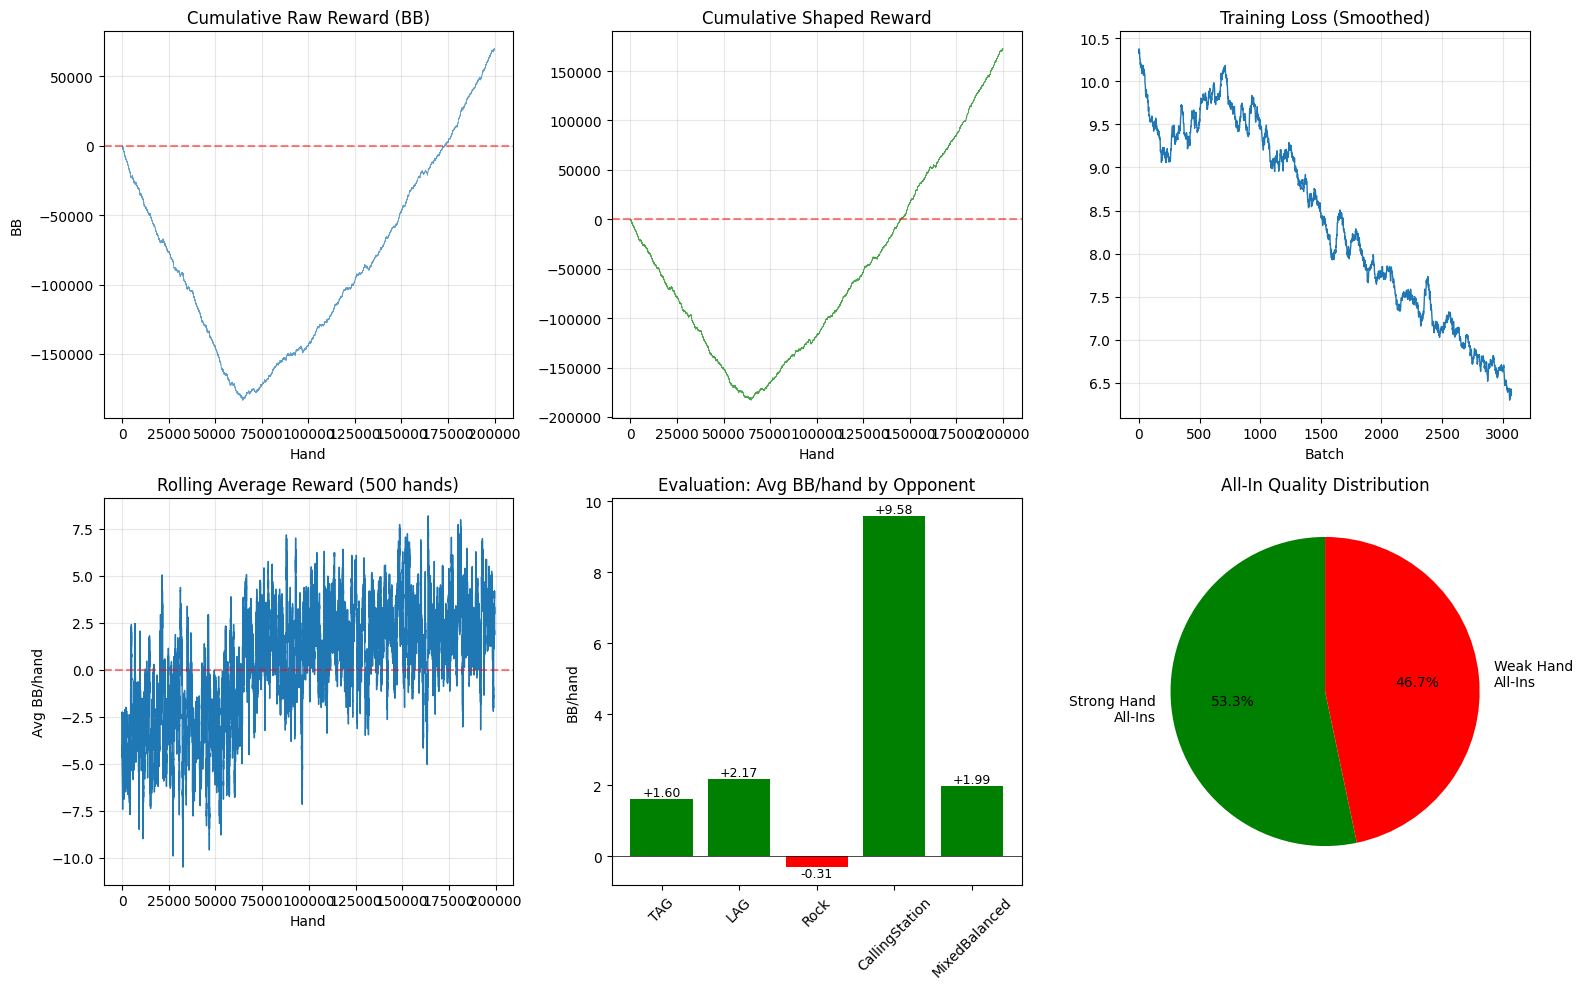


Results saved to v14_training_results.png


In [9]:
# ============================================
# Plotting (V11/V12/V13 Style)
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Cumulative reward
ax = axes[0, 0]
cumulative = np.cumsum(rewards)
ax.plot(cumulative, linewidth=0.5, alpha=0.7)
ax.set_title('Cumulative Raw Reward (BB)')
ax.set_xlabel('Hand')
ax.set_ylabel('BB')
ax.axhline(0, color='r', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

# Shaped cumulative
ax = axes[0, 1]
cumulative_s = np.cumsum(shaped)
ax.plot(cumulative_s, linewidth=0.5, alpha=0.7, color='green')
ax.set_title('Cumulative Shaped Reward')
ax.set_xlabel('Hand')
ax.axhline(0, color='r', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

# Loss
ax = axes[0, 2]
if losses:
    window = min(50, len(losses))
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    ax.plot(smoothed, linewidth=1)
ax.set_title('Training Loss (Smoothed)')
ax.set_xlabel('Batch')
ax.grid(True, alpha=0.3)

# Rolling average
ax = axes[1, 0]
window = 500
if len(rewards) >= window:
    rolling = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax.plot(rolling, linewidth=1)
ax.set_title(f'Rolling Average Reward ({window} hands)')
ax.set_xlabel('Hand')
ax.set_ylabel('Avg BB/hand')
ax.axhline(0, color='r', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

# Per-opponent results
ax = axes[1, 1]
opp_names = list(eval_results.keys())
opp_avgs = [eval_results[o]['avg'] for o in opp_names]
colors = ['green' if a > 0 else 'red' for a in opp_avgs]
bars = ax.bar(opp_names, opp_avgs, color=colors)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('Evaluation: Avg BB/hand by Opponent')
ax.set_ylabel('BB/hand')
ax.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, opp_avgs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:+.2f}',
            ha='center', va='bottom' if val >= 0 else 'top', fontsize=9)

# V14: Risk analysis pie chart
ax = axes[1, 2]
if risk_metrics['allin_count'] > 0:
    labels = ['Strong Hand\nAll-Ins', 'Weak Hand\nAll-Ins']
    sizes = [risk_metrics['allin_with_strong'], risk_metrics['allin_with_weak']]
    colors_pie = ['green', 'red']
    ax.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
    ax.set_title('All-In Quality Distribution')
else:
    ax.text(0.5, 0.5, 'No All-Ins Recorded', ha='center', va='center')
    ax.set_title('All-In Quality Distribution')

plt.tight_layout()
plt.savefig('v14_training_results.png', dpi=150)
plt.show()
print("\nResults saved to v14_training_results.png")

In [10]:
# Save the trained model
torch.save({
    'model_state_dict': agent.model.state_dict(),
    'target_state_dict': agent.target_model.state_dict(),
    'epsilon': agent.epsilon,
    'eval_results': eval_results,
    'risk_metrics': risk_metrics,
    'version': 'v14_advanced_reward_shaping'
}, 'poker_agent_v14.pt')
print("Model saved to poker_agent_v14.pt")

Model saved to poker_agent_v14.pt
